In [4]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Iterable
from copy import deepcopy

c:\Users\Benoit\miniconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## I) Déplacer un Tensor sur GPU

## II) Déplacer un Module sur GPU

## III) Les convolutions

## Exercice I

Définir et entraîner un modèle de classification d'images

In [309]:
x = np.load("../datasets/CIFAR10/CIFAR-10.npy")
y = np.load("../datasets/CIFAR10/CIFAR-10-labels.npy")
labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [310]:
def split(*args: tuple[np.ndarray], fracs: tuple[float] = (0.7, 0.15, 0.15)) -> list[tuple[np.ndarray]]:
    """
    split data in 
    """
    total = sum(fracs)
    fracs = tuple(f/total for f in fracs)
    L = len(args[0])
    indexes = np.random.permutation(L)
    start = 0
    results = []
    for f in fracs:
        end = start + int(f*L)
        results.append(tuple(array[indexes[start:end]] for array in args))
    return results



In [311]:
train_data, val_data, test_data = split(x, y)

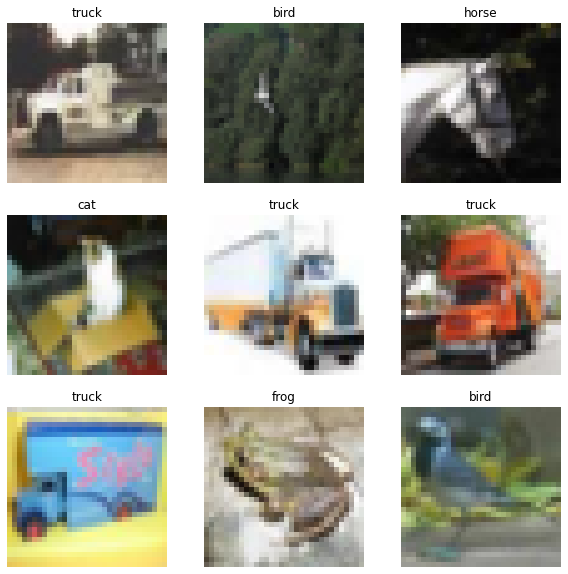

In [312]:
x_test, y_test = test_data
f, axes = plt.subplots(figsize=[10, 10], nrows=3, ncols=3)
i = 0
for axs in axes:
    for ax in axs:
        ax.imshow(x_test[i].transpose(1, 2, 0))
        ax.axis("off")
        ax.set_title(labels[y_test[i]])
        i += 1

In [330]:
def accuracy(predicted: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    """
    returns the accuracy metric of a prediction
    """
    assert predicted.shape == target.shape
    return torch.sum(predicted == target).detach().cpu().item()/len(target)

def inputs_to_tensor(x) -> torch.Tensor:
    """
    converts an image array input into tensor
    """
    return torch.tensor(x/255., dtype=torch.float32)

def target_to_tensors(y: np.ndarray) -> torch.Tensor:
    """
    converts a target numpy array to tensor
    """
    return torch.tensor(y, dtype=torch.long)

def arrays_to_tensors(x: np.ndarray, y: np.ndarray) -> tuple[torch.Tensor]:
    """
    transforms numpy arrays to tensors
    """
    return (inputs_to_tensor(x), target_to_tensors(y))

class batchifyer:
    """
    transforms numpy arrays into batches of torch tensor
    """

    def __init__(self, *args: tuple[np.ndarray], n_batches: int = 1, batch_size: int = 100):
        self.args = args
        self.n_batches = n_batches
        self.batch_size = batch_size

    def __iter__(self):
        return self.get_batches()

    def get_batches(self) -> Iterable[torch.Tensor]:
        L = len(self.args[0])
        indexes = np.random.permutation(L)
        for i in range(self.n_batches):
            x, y = (array[indexes[i*self.batch_size:(i+1)*self.batch_size]] for array in self.args)
            yield arrays_to_tensors(x, y)

In [321]:
class Block(torch.nn.Module):
    """
    A block is a set of convolution/max pooling/activation/batch normalization
    """

    def __init__(self, in_features: int, out_features: int, activation: Callable = torch.relu, kernel_size: tuple[int] = (3, 3), pool: tuple[int, int] = (2, 2)):
        super().__init__()
        self.convolution = torch.nn.Conv2d(in_features, out_features, kernel_size, (1, 1), padding="same")
        self.pool = torch.nn.MaxPool2d(pool)
        self.activation = activation
        self.batch_norm = torch.nn.BatchNorm2d(out_features)
    
    def forward(self, X):
        return self.batch_norm(self.activation(self.pool(self.convolution(X))))


class ImageClassifier(torch.nn.Module):
    """
    An Image classifier is a CNN that classifies Images
    """

    def __init__(self, in_features: int, n_classes: int, features: list[int], activation: Callable = torch.relu, kernel_size: tuple[int] = (3, 3), pool: tuple[int, int] = 2):
        super().__init__()
        self.blocks = torch.nn.ModuleList()
        for out_features in features:
            self.blocks.append(Block(in_features, out_features, activation, kernel_size, pool))
            in_features = out_features
        self.output = torch.nn.Conv2d(out_features, n_classes, kernel_size=(1, 1), padding="same")
    
    def forward(self, X):
        """
        Parameters
        ----------
        X : torch.Tensor
            tensor of floats of shape (N, C, H, W)
        """
        X = X.to(self.device)
        for block in self.blocks:
            X = block(X)
        X = self.output(X)
        N, C, H, W = X.shape
        return X.reshape(N, C, -1).mean(dim=-1)

    def predict(self, X: torch.Tensor) -> torch.Tensor:
        """
        perform a prediction of the model
        """
        self.eval()
        with torch.no_grad():
            Y = self(X)
        return Y.max(dim=1).indices
    
    def loss(self, X: torch.Tensor, Y: torch.Tensor) -> torch.Tensor:
        """
        loss of the model
        """
        y_pred = self(X)
        return F.cross_entropy(y_pred, Y.to(y_pred.device))
    
    def metric(self, X: torch.Tensor, Y: torch.Tensor):
        """
        metric of the model
        """
        y_pred = self.predict(X)
        return accuracy(y_pred, Y.to(y_pred.device))

    @property
    def device(self) -> torch.device:
        return self.output.weight.device

In [322]:
def train_loop(model: torch.nn.Module, optimizer: torch.optim.Optimizer, train_data: Iterable[tuple[torch.Tensor]], val_data: Iterable[tuple[torch.Tensor]], n_steps: int = 1000, patience: int = 100, keep_best: bool = True):
    """
    train the model for the specified number of steps, or untilearly stopping
    """
    best_state = deepcopy(model.state_dict())
    best_step = 0
    best_metric = 0.
    try:
        for step in range(n_steps):
            optimizer.zero_grad()
            # train loss
            model.train()
            losses = []
            for x, y in train_data:
                loss = model.loss(x, y)
                loss.backward()
                losses.append(loss.item())
            loss = sum(losses)/len(losses)
            # val metric
            model.eval()
            metrics = []
            for x, y in val_data:
                metrics.append(model.metric(x, y))
            metric = sum(metrics) / len(metrics)
            # checkpointing
            if metric > best_metric:
                best_metric = metric
                best_step = step
                if keep_best:
                    best_state = deepcopy(model.state_dict())
            elif step - best_step > patience:
                print("early stoping")
                break
            # optimizer steping
            optimizer.step()
            # printing
            print(f"Step {step}: loss = {loss:.3g} metric = {metric:.2%}")

    except KeyboardInterrupt:
        print("interrupted by user")
    if keep_best:
        model.load_state_dict(best_state)

In [323]:
model = ImageClassifier(3, len(labels), [32, 64, 128, 256])
model.to("cuda:0")
train = batchifyer(*train_data, n_batches=1, batch_size=10000)
val = batchifyer(*val_data, n_batches=1, batch_size=10000)
optimizer = torch.optim.Adam(model.parameters(), lr=1.0E-3)
train_loop(model, optimizer, train, val, n_steps=10000, patience=1000)

Step 0: loss = 2.4 metric = 10.04%
Step 1: loss = 2.09 metric = 10.04%
Step 2: loss = 1.97 metric = 10.04%
Step 3: loss = 1.83 metric = 10.07%
Step 4: loss = 1.76 metric = 10.04%
Step 5: loss = 1.72 metric = 12.71%
Step 6: loss = 1.67 metric = 10.09%
Step 7: loss = 1.61 metric = 10.78%
Step 8: loss = 1.56 metric = 11.29%
Step 9: loss = 1.54 metric = 10.33%
Step 10: loss = 1.5 metric = 10.22%
Step 11: loss = 1.49 metric = 10.63%
Step 12: loss = 1.46 metric = 11.11%
Step 13: loss = 1.44 metric = 10.78%
Step 14: loss = 1.42 metric = 10.22%
Step 15: loss = 1.39 metric = 10.33%
Step 16: loss = 1.38 metric = 11.42%
Step 17: loss = 1.36 metric = 13.87%
Step 18: loss = 1.32 metric = 14.72%
Step 19: loss = 1.34 metric = 14.61%
Step 20: loss = 1.3 metric = 14.12%
Step 21: loss = 1.28 metric = 13.32%
Step 22: loss = 1.26 metric = 13.12%
Step 23: loss = 1.24 metric = 13.56%
Step 24: loss = 1.24 metric = 13.34%
Step 25: loss = 1.22 metric = 13.58%
Step 26: loss = 1.19 metric = 15.07%
Step 27: loss 

In [331]:
x, y = arrays_to_tensors(*test_data)
y_pred = model.predict(x)
acc = accuracy(y_pred, y.to(y_pred.device))
print(f"accuracy {acc:.2%}")

accuracy 32.71%


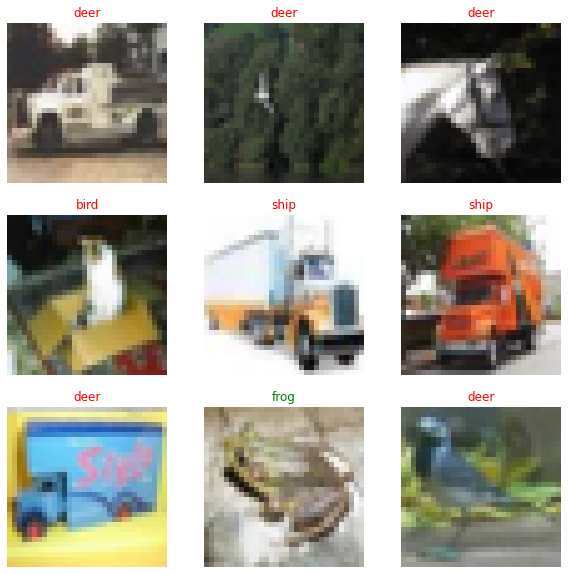

In [332]:
x_test, y_test = test_data
f, axes = plt.subplots(figsize=[10, 10], nrows=3, ncols=3)
i = 0
for axs in axes:
    for ax in axs:
        ax.imshow(x_test[i].transpose(1, 2, 0))
        ax.axis("off")
        ax.set_title(labels[y_pred[i]], color="g" if y_pred[i] == y_test[i] else "r")
        i += 1

## Exercice II

Définir et entraîner un modèle de segmentation d'images

In [333]:
import PIL
from PIL import Image, ImageDraw

In [334]:
def generate_polygons(image_shape: tuple[int, int], delta: int = 10, n_max_vertices: int = 5):
    """
    generate a set of random polygon parametrized as a list of (x, y) tuples

    Parameters
    ----------
    image_shape : tuple of int
        the (height, width) in pixels of the image to fill with polygons
    delta : int
        the 
    """
    assert n_max_vertices >= 3
    x_offset, y_offset = np.random.uniform(-delta, delta, 2)  # offset of the polygons grid
    x_spacing, y_spacing = np.arange(-delta, image_shape[1]+delta, delta)+x_offset, np.arange(-delta, image_shape[0]+delta, delta)+y_offset
    x_centers, y_centers = np.meshgrid(x_spacing, y_spacing, indexing="xy")  # coordinates of polygons centers
    Lx, Ly = x_centers.shape
    x_centers += np.random.uniform(-delta/2, delta/2, (Lx, Ly))
    y_centers += np.random.uniform(-delta/2, delta/2, (Lx, Ly))
    thetas = np.cumsum(np.random.uniform(1., 3., (Lx, Ly, n_max_vertices+1)), axis=-1)  # angle of each vertex of each polygon
    n_vertices = np.random.randint(3, n_max_vertices+1, (Lx, Ly, 1))  # number of vertices in each polygon
    thetas = thetas[..., :-1] * 2*np.pi / np.take_along_axis(thetas, n_vertices, axis=-1)
    mu, sigma = delta/2, delta/6
    radius = np.clip(np.random.normal(mu, sigma, (Lx, Ly, n_max_vertices)), 0, delta/2)  # radius of each vertex of eahc polygon
    return [[(x_center + r*np.cos(theta), y_center + r*np.sin(theta)) for r, theta, _ in zip(points_r, points_theta, range(point_n_vertices))]
            for points_r, points_theta, x_center, y_center, point_n_vertices
            in zip(radius.reshape(-1, n_max_vertices), thetas.reshape(-1, n_max_vertices), x_centers.reshape(-1), y_centers.reshape(-1), n_vertices.reshape(-1))]

def generate_image(width: int = 64, height: int = 64, delta: int = 20):
    """
    generate a an image of a polygon and it's target interior
    """
    shape = (height, width)
    img = Image.new("L", shape)
    target = Image.new("1", shape)
    img_draw = ImageDraw.Draw(img)
    target_draw = ImageDraw.Draw(target)
    n_polygons = np.random.randint(3, 6)
    for polygon in generate_polygons(shape, delta):
        img_draw.polygon(polygon, fill=None, outline="#ffffff")
        target_draw.polygon(polygon, fill="#ffffff", outline="#ffffff")
    return np.array(img, dtype=np.uint8), np.array(target, dtype=bool)

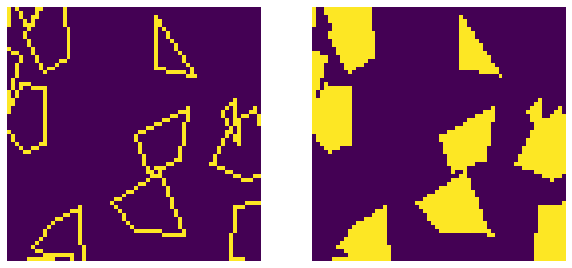

In [335]:
x, y = generate_image(64, 64, 20)
f, axes = plt.subplots(figsize=[10, 5], ncols=2)
for ax, img in zip(axes, [x, y]):
    ax.imshow(img, cmap="viridis")
    ax.axis("off")

In [341]:
class BatchesGenerator:
    """
    generate a batch of 'n' (input, target) observations when iterated over
    """
    def __init__(self, n_batches: int, batch_size : int):
        self.n_batches = n_batches
        self.batch_size = batch_size

    def __iter__(self):
        return self.get_batches()
    
    def get_batches(self):
        for _ in range(self.n_batches):
            inputs, targets = (np.stack(arrays, axis=0) for arrays in zip(*[generate_image() for _ in range(self.batch_size)]))
            yield torch.tensor(inputs/255., dtype=torch.float32), torch.tensor(targets, dtype=torch.bool)

In [342]:
def F1_score(predicted: torch.Tensor, target: torch.Tensor) -> float:
    """
    returns the F1 score of a binary classification
    """
    assert predicted.shape == target.shape
    assert predicted.dtype == torch.bool
    assert target.dtype == torch.bool
    with torch.no_grad():
        tp = torch.sum(predicted & target).detach().cpu().item()
        fp = torch.sum(~predicted & target).detach().cpu().item()
        fn = torch.sum(predicted & ~target).detach().cpu().item()
    return (2*tp) / (2*tp + fp + fn)

In [416]:
class ImageSegmenter(torch.nn.Module):

    def __init__(self, features: list[int], activation: Callable = torch.relu, kernel_size: tuple[int] = (3, 3), pool: tuple[int, int] = 2):
        super().__init__()
        self.encoder = torch.nn.ModuleList()
        in_features = 1
        for out_features in features:
            self.encoder.append(Block(in_features, out_features, activation, kernel_size, pool))
            in_features = out_features
        self.decoder = torch.nn.ModuleList()
        for out_features in features[-2::-1] + [1]:
            self.decoder.append(Block(in_features+out_features, out_features, activation, kernel_size, (1, 1)))
            in_features = out_features
        self.output = torch.nn.Conv2d(in_features, 1, (1, 1))
    
    def forward(self, X: torch.Tensor):
        feature_maps = []
        X = X.unsqueeze(1).to(self.device)
        for stage in self.encoder:
            feature_maps.append(X)
            X = stage(X)
        for stage in self.decoder:
            X = F.interpolate(X, scale_factor=2, mode="nearest")
            feature_map = feature_maps.pop()
            X = torch.cat([X, feature_map], dim=1)
            X = stage(X)
        self.output(X)
        return torch.sigmoid(X).squeeze(1)

    def predict(self, X: torch.Tensor) -> torch.Tensor:
        """
        """
        self.eval()
        with torch.no_grad():
            Y = self(X)
        return Y > 0.5
        
    def loss(self, X: torch.Tensor, Y: torch.Tensor) -> torch.Tensor:
        """
        """
        y_pred = self(X)
        return F.binary_cross_entropy(y_pred, (Y.float() / 255).to(y_pred.device))

    def metric(self, X: torch.Tensor, Y: torch.Tensor) -> torch.Tensor:
        """
        """
        y_pred = self.predict(X)
        return F1_score(y_pred > 0.5, Y.to(y_pred.device))

    @property
    def device(self) -> torch.device:
        return self.output.weight.device

In [418]:
model = ImageSegmenter([8, 16, 32])
model.to("cuda:0")
generator = BatchesGenerator(1, 1000)
optimizer = torch.optim.Adam(model.parameters(), lr=1.0E-3)
train_loop(model, optimizer, generator, generator, n_steps=10000, patience=1000)

Step 0: loss = 0.747 metric = 10.09%
Step 1: loss = 0.631 metric = 5.00%
Step 2: loss = 0.594 metric = 1.44%
Step 3: loss = 0.574 metric = 0.49%
Step 4: loss = 0.56 metric = 0.22%
Step 5: loss = 0.549 metric = 0.13%
Step 6: loss = 0.542 metric = 0.10%
Step 7: loss = 0.534 metric = 0.10%
Step 8: loss = 0.527 metric = 0.09%
Step 9: loss = 0.52 metric = 0.10%
Step 10: loss = 0.513 metric = 0.11%
Step 11: loss = 0.507 metric = 0.14%
Step 12: loss = 0.499 metric = 0.18%
Step 13: loss = 0.493 metric = 0.22%
Step 14: loss = 0.487 metric = 0.31%
Step 15: loss = 0.48 metric = 0.49%
Step 16: loss = 0.476 metric = 0.87%
Step 17: loss = 0.47 metric = 1.79%
Step 18: loss = 0.465 metric = 3.72%
Step 19: loss = 0.461 metric = 7.70%
Step 20: loss = 0.459 metric = 13.91%
Step 21: loss = 0.455 metric = 21.89%
Step 22: loss = 0.453 metric = 31.79%
Step 23: loss = 0.45 metric = 42.79%
Step 24: loss = 0.447 metric = 51.91%
Step 25: loss = 0.445 metric = 60.12%
Step 26: loss = 0.443 metric = 66.54%
Step 27:

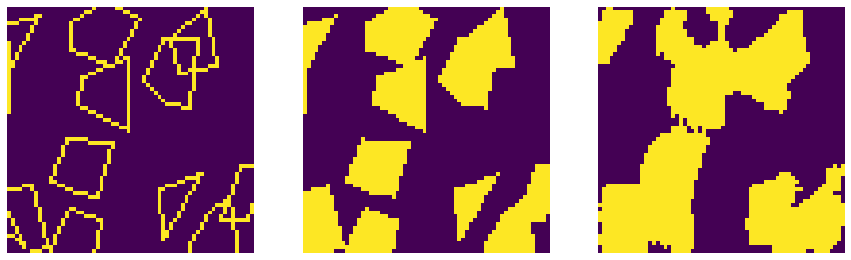

In [431]:
x, y = next(iter(BatchesGenerator(1, 1)))
y_pred = model.predict(x)
f, axes = plt.subplots(figsize=[15, 5], ncols=3)
for ax, img in zip(axes, [x[0], y[0].cpu().numpy(), y_pred[0].cpu().numpy()]):
    ax.imshow(img, cmap="viridis")
    ax.axis("off")